# Fraud Detection - Modelling

Create a model that predicts whether a transaction is fraudulent or not.

In [1]:
from multiprocessing import Pool, TimeoutError
import os
import yaml

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from fin_crime.data_processor import DataProcessor
from fin_crime.model import custom_eval_metrics, fit_xgb_classifier

# Defines

In [2]:
num_cores = os.cpu_count()
input_data_dir = os.path.join("data", "processed")

In [3]:
dp = DataProcessor(
    input_data_dir
)

In [4]:
# features
x_cols_categorical = [
    "category",
    "gender",
    "trans_hour",
    "job_short",
    "merchant",
    "merchant_state",
    "card_state"
]
x_cols_cont = [
    "amt",
    "age_at_transaction",
    "city_pop",
    
]
x_cols = x_cols_categorical + x_cols_cont

# target
y_col = "is_fraud"

# Data

In [5]:
# Compressed job titles - courtesy of ChatGPT
with open(os.path.join("data", "compressed_job_titles.yml")) as f:
    job_map = yaml.load(f, Loader=yaml.FullLoader)['compressed_job_titles']

In [6]:
df_train = pd.read_parquet(
    os.path.join(input_data_dir, "tr_fincrime_train.parquet")
)

df_eval = pd.read_parquet(
    os.path.join(input_data_dir, "tr_fincrime_test.parquet")
)

In [7]:
df_train = dp.process(df_train)
df_eval = dp.process(df_eval)

In [8]:
df_train['job_short'] = df_train['job'].replace(job_map)
df_eval['job_short'] = df_eval['job'].replace(job_map)

In [9]:
for cur_df in [df_train, df_eval]:
    cur_df[x_cols_categorical] = cur_df[x_cols_categorical].astype("category")

# Models

Recall of fraudulent transactions is the key metric used to validate model performance:

- Missing a fraudulent transaction is more expensive for the business than doing a check

## Baseline Model - Estimation

- XGBoost classifier with class-scaled loss
- Stratified K-Fold with 5 folds and 3 sets of hyperparameters

In [10]:
n_folds = 5

skf = StratifiedKFold(
    n_splits=n_folds, 
    shuffle=True,
    random_state=42
)

In [11]:
params_base = {
    'objective': 'binary:logistic',
    'scale_pos_weight': (df_train[y_col] == 0).sum() / (df_train[y_col] == 1).sum(),
    "learning_rate": 0.01,
}

params_low_reg = params_base | {
    "min_child_weight": 1,
    "gamma": 0.01,
    "max_depth": 15,
    "subsample": 1,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0
}

params_med_reg = params_base | {
    "min_child_weight": 10,
    "gamma": 0.1,
    "max_depth": 10,
    "subsample": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1
}

params_high_reg = params_base | {
    "min_child_weight": 25,
    "gamma": 0.5,
    "max_depth": 8,
    "subsample": 0.5,
    "reg_alpha": 0.5,
    "reg_lambda": 0.5
}

params = {
    "params_low_reg": params_low_reg,
    "params_med_reg": params_med_reg,
    "params_high_reg": params_high_reg,
}

num_boost_round = 1000
early_stopping_rounds = 50
fit_timeout = 600  # Adjust if necessary

In [12]:
# Iterating over hyperparameters
out_dict = {}

for cur_name, cur_params in tqdm(params.items()):
    skf_gen = skf.split(df_train[x_cols], df_train[y_col])

    with Pool(processes=min(num_cores - 1, n_folds)) as pool:
        out = pool.starmap_async(
            fit_xgb_classifier, 
            [
                (cur_params, df_train, x_cols, y_col, train_idx, test_idx, num_boost_round, early_stopping_rounds) 
                for _, (train_idx, test_idx) in enumerate(skf_gen)
            ]
        )
    
        try:
            result = out.get(timeout=fit_timeout)
        except TimeoutError:
            print("Timeout")
            result = None

    out_dict[cur_name] = result

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:03<00:00, 81.33s/it]


## Baseline Model - Performance

- There is a trade-off between precision and recall which we have to make - `params_med_reg` set of hyperparameters (middle of the road amount of regularisation) could be an OK choice to keep the amount of false positives under control
- Higher regularisation gives an overall best fraud recall

In [13]:
# Preparing Metrics
metric_list = []

for cur_name, cur_out in out_dict.items():
    for cur_fold, _ in enumerate(cur_out):
        
        df_metrics_train = pd.DataFrame(
            cur_out[cur_fold][0]["train"]
        )
        
        df_metrics_eval = pd.DataFrame(
            cur_out[cur_fold][0]["eval"]
        )
        
        df_metrics_train["step"] = df_metrics_train.index.values
        df_metrics_eval["step"] = df_metrics_eval.index.values
        
        df_metrics_train["type"] = "train"
        df_metrics_eval["type"] = "eval"
        
        df_metrics = pd.concat([df_metrics_train, df_metrics_eval], ignore_index=True)
        df_metrics["fold"] = cur_fold
        df_metrics["param"] = cur_name

        metric_list.append(df_metrics)

In [14]:
df_metrics_all = pd.concat(metric_list)

df_metrics_agg = df_metrics_all.groupby(
    ["param", "type", "step"],
)[["f1", "precision_class_1", "recall_class_1"]].mean()

df_metrics_agg = df_metrics_agg.join(
    df_metrics_all.groupby(
        ["param", "type", "step"],
    )["recall_class_1"].size().to_frame("count")
)

df_metrics_agg = df_metrics_agg.loc[
    df_metrics_agg["count"] == n_folds
]

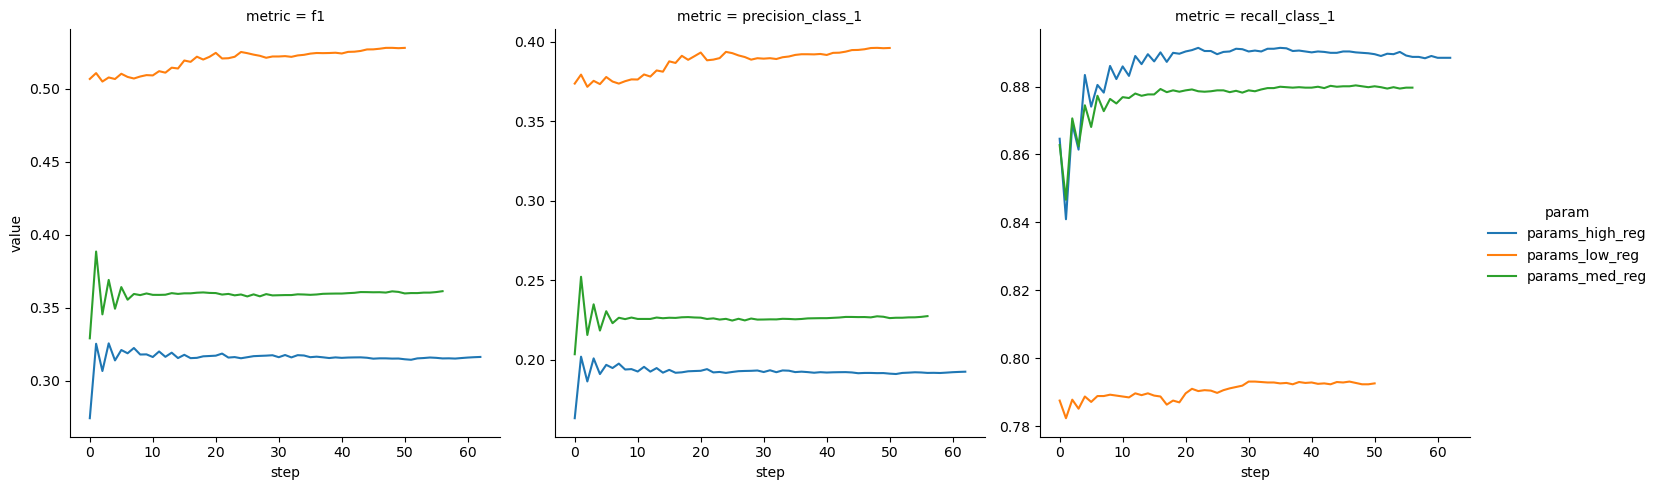

In [15]:
df_plot = df_metrics_agg.reset_index().melt(
    id_vars=['param', 'type', 'step'],
    var_name='metric',
    value_vars=['f1', 'precision_class_1', 'recall_class_1']
)

sns.relplot(
    data=df_plot[df_plot['type'] != 'train'],
    x='step',
    y='value',
    hue='param',
    col='metric',
    kind='line',
    facet_kws={"sharey": False}
)

Text(0.5, 1.02, 'Fraud Recall Bias')

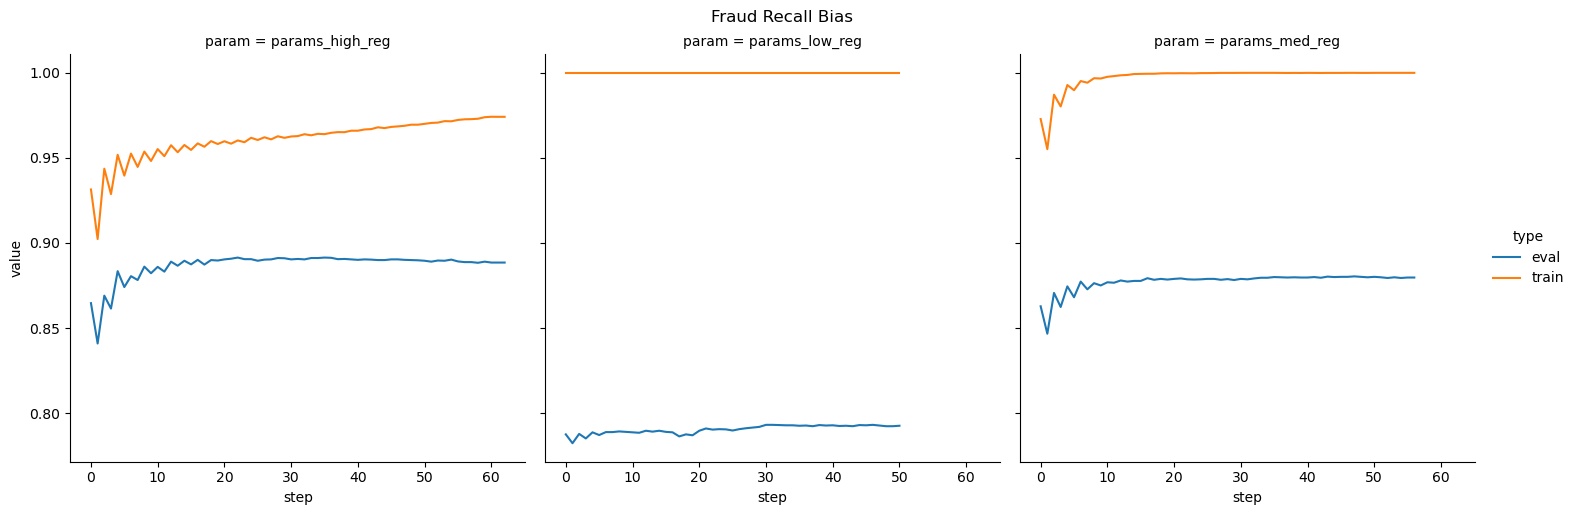

In [16]:
df_plot = df_metrics_agg.reset_index().melt(
    id_vars=['param', 'type', 'step'],
    var_name='metric',
    value_vars=['f1', 'precision_class_1', 'recall_class_1']
)

sns.relplot(
    data=df_plot[df_plot['metric'] == 'recall_class_1'],
    x='step',
    y='value',
    hue='type',
    col='param',
    kind='line',
    facet_kws={"sharey": True}
)

plt.suptitle('Fraud Recall Bias', y=1.02)

## Baseline Model - Final Performance

Using `params_high_reg` and full data

In [17]:
dtrain = xgb.DMatrix(df_train[x_cols], label=df_train[y_col], enable_categorical=True)
deval = xgb.DMatrix(df_eval[x_cols], label=df_eval[y_col], enable_categorical=True)

evals = [(dtrain, 'train'), (deval, 'eval')]

In [18]:
cur_evals_result = {}

model = xgb.train(
    params_high_reg,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=cur_evals_result,
    early_stopping_rounds=early_stopping_rounds,
    custom_metric=custom_eval_metrics,
    maximize=True,
    verbose_eval=None
)

In [19]:
# Best recall achieved
pd.DataFrame(cur_evals_result['eval'])['recall_class_1'].max()

0.817716

<Axes: >

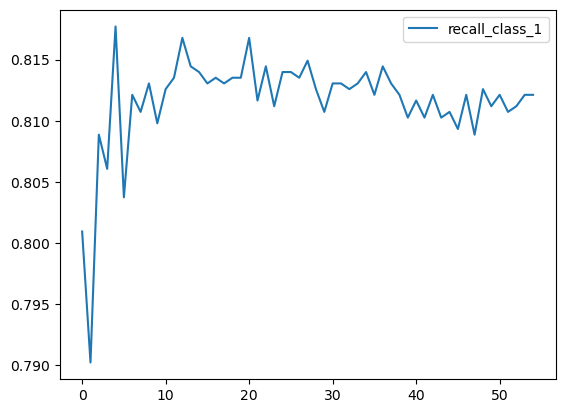

In [20]:
pd.DataFrame(cur_evals_result['eval']).plot(y='recall_class_1')

# Further Improvements

**Methods**

- More comprehensive grid-search
- Use over-sampling / over-sampling as well as class weighting
- Check feature contributions (SHAP)
- Other models (e.g. Random Forest, GNN-based for better capture of spacial data)
- Examine the time-series dimension of the data

**Data**

- Collect more
- Merchants' histories: how long have they been active, what's their track record, KYB profiles.
- Data from law enforcement agencies: police, court orders, fraud office, etc.
- Cyber-security databases: there are sources which inform users if their details were stolen
- Potential links to organised crime or money laundering: a longer shot given, e.g., Dow Jones PEP/SIP/Sanctions database is unlikely to feature smaller merchants, but worth a shot
- Trusted online reviews for merchants